In [1]:
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical computations

import matplotlib.pyplot as plt  # Plotting library
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
from matplotlib import rcParams  # For configuring font settings

from sklearn.preprocessing import (
    MinMaxScaler,  # Min-max normalization
    StandardScaler,  # Standardization
    Normalizer,  # Normalize samples individually to unit norm
    PolynomialFeatures  # Generate polynomial features
)

from sklearn.model_selection import train_test_split, RandomizedSearchCV  # Data splitting and hyperparameter tuning
from sklearn.linear_model import LinearRegression, RANSACRegressor  # Linear and RANSAC regression
from sklearn.kernel_ridge import KernelRidge  # Kernel Ridge regression

from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    max_error,
    explained_variance_score  # Various metrics for evaluating regression and classification models
)

import xgboost as xgb  # XGBoost library for gradient boosting
from xgboost import plot_importance  # Plotting feature importance for XGBoost

import seaborn as sns  # Statistical data visualization
from scipy.stats import pearsonr  # Pearson correlation calculation
from scipy.interpolate import splev, splrep  # Data smoothing with interpolation

from sklearn.inspection import PartialDependenceDisplay, partial_dependence  # Partial dependence plots
from scipy.optimize import curve_fit  # For fitting custom curve models

import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Configure font to display Calibri and handle minus sign issues
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Calibri']
plt.rcParams['axes.unicode_minus'] = False

C:\Users\hai\anaconda3\envs\geopd\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. INCOME & ESV tradeoff

## 2.1 Points

In [2]:
df = pd.read_csv(r'PPF_point_1km.csv', index_col=0)
df.head(5)

,County,Town,Type,Income,ESV
OBJECTID,,,,,
20,川岛镇,江门市台山市川岛镇,3,0.199315,0.333703
39,川岛镇,江门市台山市川岛镇,3,0.249024,0.323801
47,川岛镇,江门市台山市川岛镇,3,0.225105,0.693933
48,川岛镇,江门市台山市川岛镇,3,0.234412,0.759637
49,川岛镇,江门市台山市川岛镇,3,0.152010,0.681101


In [3]:
df.describe()

,Type,Income,ESV
count,41686.000000,41686.000000,41686.000000
mean,2.296814,0.210871,0.349276
std,1.443781,0.101026,0.194611
min,0.000000,0.000008,0.121449
25%,0.000000,0.137323,0.198689
50%,3.000000,0.190019,0.307192
75%,3.000000,0.270944,0.428819
max,4.000000,0.729149,0.904930


In [4]:
def custom_normalize(column, lower=0, upper=1.0):
    normalized = (column - column.min()) / (column.max() - column.min())
    return normalized * (upper - lower) + lower

df['Income'] = custom_normalize(df['Income'])
df['ESV'] = custom_normalize(df['ESV'])

In [5]:
income_esv_0 = df[df['Type'] == 0]
print(income_esv_0.shape)

income_esv_1 = df[df['Type'] == 1]
print(income_esv_1.shape)

income_esv_2 = df[df['Type'] == 2]
print(income_esv_2.shape)

income_esv_3 = df[df['Type'] == 3]
print(income_esv_3.shape)

income_esv_4 = df[df['Type'] == 4]
print(income_esv_4.shape)

(10461, 5)
(1738, 5)
(429, 5)
(23083, 5)
(5975, 5)


In [6]:
df.describe()

,Type,Income,ESV
count,41686.000000,41686.000000,41686.000000
mean,2.296814,0.289194,0.290788
std,1.443781,0.138555,0.248393
min,0.000000,0.000000,0.000000
25%,0.000000,0.188325,0.098586
50%,3.000000,0.260596,0.237074
75%,3.000000,0.371583,0.392313
max,4.000000,1.000000,1.000000


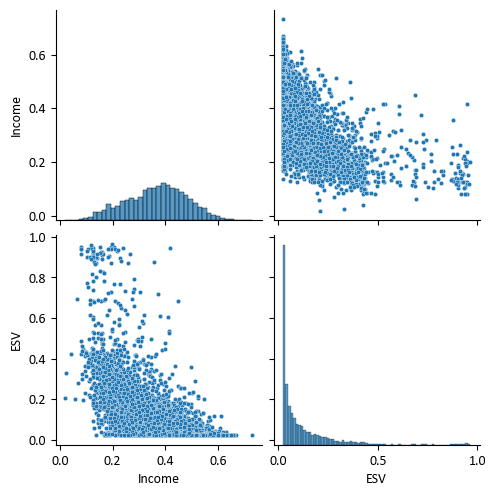

In [7]:
# sb.pairplot(data = esv_ev_normalized,vars = ['sum_income_1km', 'ESV_sum'])
sb.pairplot(data = income_esv_4,vars = ['Income', 'ESV'], plot_kws={'s': 10})

## Sigmoid function

Dataset 0 - Sigmoid Fit: y = 0.99 / (1 + exp(20.94 * (x - 0.80))), R² Value: 0.979


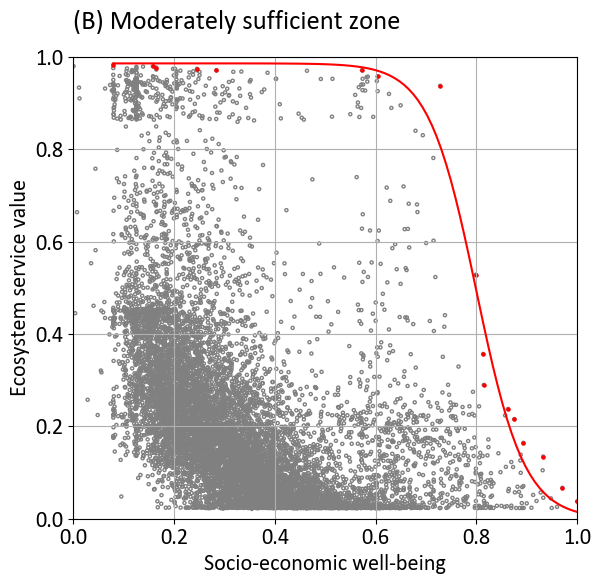

Dataset 1 - Sigmoid Fit: y = 0.94 / (1 + exp(19.63 * (x - 0.60))), R² Value: 0.985


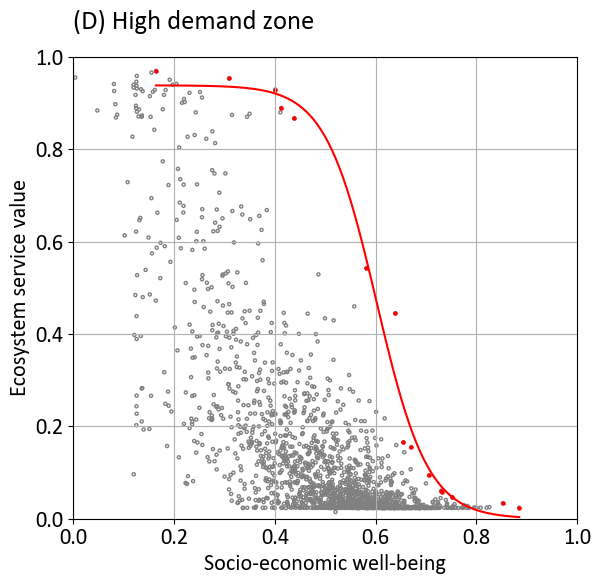

Dataset 2 - Sigmoid Fit: y = 0.41 / (1 + exp(24.49 * (x - 0.61))), R² Value: 0.987


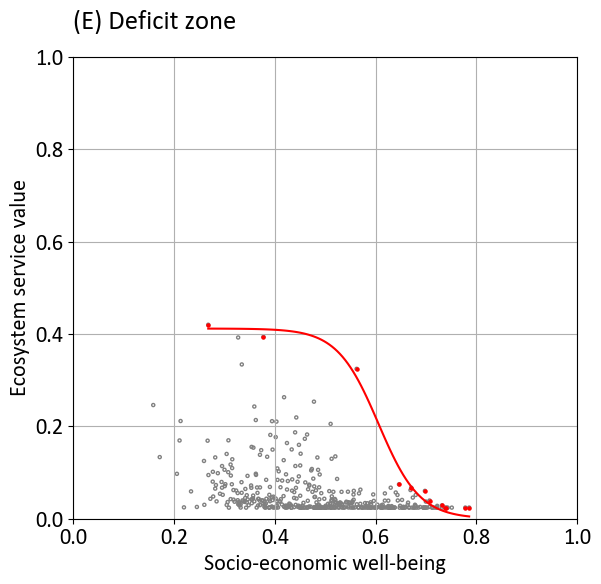

Dataset 3 - Sigmoid Fit: y = 0.96 / (1 + exp(73.04 * (x - 0.71))), R² Value: 0.980


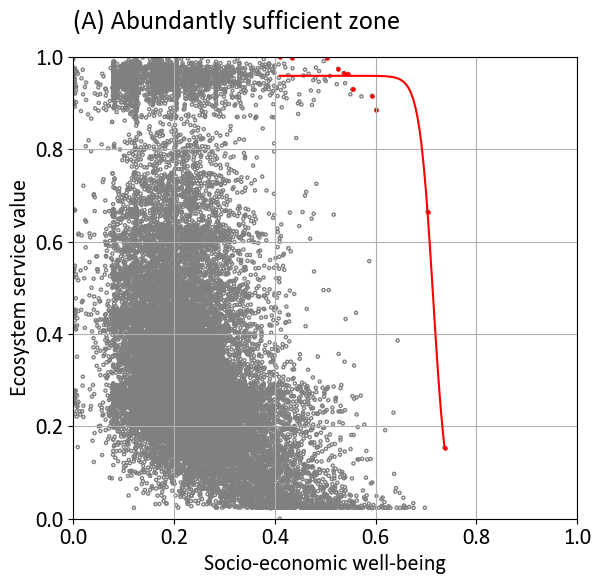

Dataset 4 - Sigmoid Fit: y = 0.97 / (1 + exp(27.29 * (x - 0.48))), R² Value: 0.985


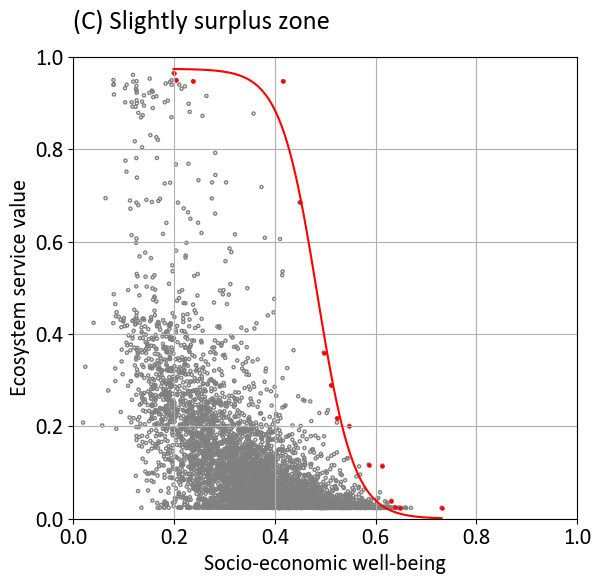

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define Sigmoid function
def sigmoid(x, L, x0, k):
    """Sigmoid function for curve fitting."""
    return L / (1 + np.exp(-k * (x - x0)))

# Find Pareto-optimal points
def find_pareto_optimal_points(df):
    """Identify Pareto-optimal points based on 'Income' and 'ESV'."""
    df = df.sort_values(by='Income', ascending=False)
    pareto_optimal = []
    max_esv = -np.inf
    for row in df.itertuples(index=False):
        if row.ESV > max_esv:
            pareto_optimal.append(row)
            max_esv = row.ESV
    pareto_optimal_df = pd.DataFrame(pareto_optimal, columns=df.columns)
    return pareto_optimal_df

# Calculate distance to the sigmoid curve
def calculate_distance_to_curve(df, popt_sigmoid):
    """Calculate the normalized distance of each sample to the sigmoid curve."""
    curve_points = np.linspace(df['Income'].min(), df['Income'].max(), 1000)
    curve_values = sigmoid(curve_points, *popt_sigmoid)
    df['distance_to_curve'] = df.apply(
        lambda row: np.min(np.sqrt((curve_points - row['Income'])**2 + (curve_values - row['ESV'])**2)), axis=1
    )
    max_distance = df['distance_to_curve'].max()
    df['normalized_distance'] = df['distance_to_curve'] / max_distance
    df['integrated_well_being'] = 1 - df['normalized_distance']
    return df

# List of data sets and titles
income_esv_list = [income_esv_0, income_esv_1, income_esv_2, income_esv_3, income_esv_4]
titles = [
    "(B) Moderately sufficient zone",
    "(D) High demand zone",
    "(E) Deficit zone",
    "(A) Abundantly sufficient zone",
    "(C) Slightly surplus zone"
]

# Loop through datasets and titles for analysis and visualization
for i, (income_esv, title) in enumerate(zip(income_esv_list, titles)):
    # Find Pareto-optimal points
    pareto_optimal_points = find_pareto_optimal_points(income_esv)
    
    # Scatter plot of points
    plt.figure(figsize=(6.5, 6))
    plt.scatter(income_esv['Income'], income_esv['ESV'], color='none', edgecolors='grey', marker='o', s=5, label='Non-Pareto-optimal points')
    plt.scatter(pareto_optimal_points['Income'], pareto_optimal_points['ESV'], color='red', s=5, label='Pareto-optimal points')
    
    # Fit Sigmoid function
    p0 = [max(pareto_optimal_points['ESV']), np.median(pareto_optimal_points['Income']), 1]
    popt_sigmoid, _ = curve_fit(sigmoid, pareto_optimal_points['Income'], pareto_optimal_points['ESV'], p0=p0)
    
    # Calculate R² for sigmoid fit
    y_fit_sigmoid = sigmoid(pareto_optimal_points['Income'], *popt_sigmoid)
    ss_res_sigmoid = np.sum((pareto_optimal_points['ESV'] - y_fit_sigmoid) ** 2)
    ss_tot_sigmoid = np.sum((pareto_optimal_points['ESV'] - np.mean(pareto_optimal_points['ESV'])) ** 2)
    r_squared_sigmoid = 1 - (ss_res_sigmoid / ss_tot_sigmoid)
    
    # Construct function expression for sigmoid
    sigmoid_func_str = f'y = {popt_sigmoid[0]:.2f} / (1 + exp({-popt_sigmoid[2]:.2f} * (x - {popt_sigmoid[1]:.2f})))'
    print(f"Dataset {i} - Sigmoid Fit: {sigmoid_func_str}, R² Value: {r_squared_sigmoid:.3f}")
    
    # Plot the fitted sigmoid curve
    x_fit = np.linspace(min(pareto_optimal_points['Income']), max(pareto_optimal_points['Income']), 100)
    plt.plot(x_fit, sigmoid(x_fit, *popt_sigmoid), 'r-', label=f'Sigmoid Fit: {sigmoid_func_str}, R² Value: {r_squared_sigmoid:.3f}')
    
    # Set font and plot labels
    plt.xlabel('Socio-economic well-being', fontsize=16)
    plt.ylabel('Ecosystem service value', fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(title, loc='left', pad=20)
    plt.grid(True)

    # Save plot
    plt.savefig(f'Figure/PPF/{title.replace(" ", ".")}.png', bbox_inches='tight')

    # Calculate integrated well-being
    income_esv = calculate_distance_to_curve(income_esv, popt_sigmoid)
    
    plt.show()